You can perform PID on MI(r;(x,v)), and compare the result of different 'x'.
'x' can from experimental data or produce in this code for different Tau (Gramma) or cutoff frequency
'r' can be real responses of RGC or from NGD or from x+$\Delta$*v.
Using 20200408 Chou's data, unit2.

# Functions

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib.ticker import MaxNLocator
import math
from scipy import signal
from scipy.fftpack import fft
from scipy import ndimage
from scipy.io import loadmat
import os
%matplotlib inline

In [2]:
def Histo3D2Dict(P):
    PDF = dict()
    for i in range(np.size(P, 0)):
        for j in range(np.size(P, 1)):
            for k in range(np.size(P, 2)):
                PDF[(k,i,j)] = float(P[i,j,k])
    return PDF

In [3]:
## EqualState assign states with equal possibility for input array x
def EqualState(x, num_state):
    xs=np.sort(x)
    binlen=int(len(x)/num_state-0.5) #round
    edges = xs[np.arange(num_state+1)*binlen]
    xstate=np.zeros(len(x))
    for i in range(num_state):
        xstate[x>=edges[i]] = i
    xstate = xstate.astype(int)
    return xstate, edges

In [4]:
def PIfunc(r, x, v, dt, window):
    negshift=window[0] # second
    posshift=window[1] # second
    shiftlen=(posshift-negshift)/dt+1
    timeshift=np.linspace(negshift,posshift,int(shiftlen))
    bitshift=np.linspace(negshift/dt,posshift/dt,int(shiftlen),dtype = 'int16')
    Information = dict()
#     Information[('BROJA_2PID','SI')]=np.zeros(len(bitshift))
#     Information[('BROJA_2PID','UIx')]=np.zeros(len(bitshift))
#     Information[('BROJA_2PID','UIv')]=np.zeros(len(bitshift))
#     Information[('BROJA_2PID','CI')]=np.zeros(len(bitshift))
    Information[('Beer','Red')]=np.zeros(len(bitshift))
    Information[('Beer','UIx')]=np.zeros(len(bitshift))
    Information[('Beer','UIv')]=np.zeros(len(bitshift))
    Information[('Beer','Syn')]=np.zeros(len(bitshift))
    
    Redun =np.zeros(len(bitshift))
    MIxr=np.zeros(len(bitshift))
    MIvr=np.zeros(len(bitshift))
    MIxvR=np.zeros(len(bitshift))
    parms = dict()
    parms['max_iters'] = 20
    # shifted data
    # shift>0 => y shifted to positive side
    for i in range(len(bitshift)):
        xx=[]
        vv=[]
        rr=[]
        shift=bitshift[i]
        if shift>0:
            xx=x[shift:]
            vv=v[shift:]
            rr=r[:(-1*shift)]
        elif shift==0:
            xx=x
            vv=v
            rr=r
        elif shift<0:
            xx=x[:shift]
            vv=v[:shift]
            rr=r[(-1*shift):]
        #find weight of each states by 3D histogram 
        xedges = np.append(np.unique(xx),(max(xx)+1))
        vedges = np.append(np.unique(vv),(max(vv)+1))
        redges = np.append(np.unique(rr),(max(rr)+1))
        dat = np.concatenate((xx[:,np.newaxis], vv[:,np.newaxis],rr[:,np.newaxis]), axis=1)
        N, edges = np.histogramdd(dat, bins=(xedges, vedges, redges))
        #Calculate all kinds of probability and make sure the shape of them, 0 -> x, 1 -> v, 2 -> r
        px=(np.sum(N,axis=(1,2))/np.sum(N))[:, np.newaxis, np.newaxis]
        pv=(np.sum(N,axis=(0,2))/np.sum(N))[np.newaxis, :, np.newaxis]
        pr=(np.sum(N,axis=(0,1))/np.sum(N))[np.newaxis ,np.newaxis, :]
        pxv=(np.sum(N,axis=2)/np.sum(N))[:, :, np.newaxis]
        pxr=(np.sum(N,axis=1)/np.sum(N))[:, np.newaxis, :]
        pvr=(np.sum(N,axis=0)/np.sum(N))[np.newaxis, :, :]
        pxvr=(N/np.sum(N))
        
                
#         PDF=Histo3D2Dict(pxvr)
#         BROJA_2PID = pid(PDF, cone_solver="ECOS", output=0, **parms)
#         Information[('BROJA_2PID','SI')][i]=BROJA_2PID['SI']/dt
#         Information[('BROJA_2PID','UIx')][i]=BROJA_2PID['UIY']/dt
#         Information[('BROJA_2PID','UIv')][i]=BROJA_2PID['UIZ']/dt
#         Information[('BROJA_2PID','CI')][i]=BROJA_2PID['CI']/dt
        

        MIxr=np.nansum(pxr*np.log2(pxr/px/pr))/dt
        MIvr=np.nansum(pvr*np.log2(pvr/pv/pr))/dt
        MIxvR=np.nansum(pxvr*np.log2(pxvr/pxv/pr))/dt
        PI_xR = np.nansum(pxr*np.log2(pxr/px/pr), axis = (0,1))
        PI_vR = np.nansum(pvr*np.log2(pvr/pv/pr), axis = (0,1))
        R = sum(np.minimum(PI_xR, PI_vR))/dt
        Information[('Beer','Red')][i] = R
        Information[('Beer','UIx')][i] = MIxr - R
        Information[('Beer','UIv')][i] = MIvr - R
        Information[('Beer','Syn')][i] = MIxvR - MIxr - MIvr + R

    return timeshift, Information

In [5]:
# activation function
def nA(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= 1
    return(y)

# activation function
def nA2(x,theta1, theta2):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta2>0:
            y[i]= 2
        elif x[i]- theta1>0:
            y[i]= 1
    return(y)

In [6]:
def STA(r, x, v, dt, window):
    negshift=round(window[0]/dt) # second
    posshift=round(window[1]/dt) # second
    xSTS = np.zeros(posshift-negshift)
    vSTS = np.zeros(posshift-negshift)
    for i in np.arange(-negshift, len(r)-posshift):
        xSTS = xSTS + x[i+negshift:i+posshift]*r[i]
        vSTS = vSTS + v[i+negshift:i+posshift]*r[i]
    xSTA = xSTS/sum(r[-negshift:len(r)-posshift])
    vSTA = vSTS/sum(r[-negshift:len(r)-posshift])
    time = np.arange(negshift*dt, posshift*dt, dt)
    return time, xSTA, vSTA

In [7]:
def Spike_Time_Generater(rdt, dt, Garmma=1):
    rdt = rdt*Garmma
    Spike_time = []
    
    counter = 0
    post_remainer_c = 0
    p = 1
    while True:
        the_random_number = 1-np.random.rand()
        while (the_random_number < p and counter < len(rdt)):
            p *= np.exp(-rdt[counter])
            counter += 1
        if counter >= len(rdt):
            break
        remainer_c = -np.log(p/the_random_number)/rdt[counter-1]
#         if remainer_c>=1 or remainer_c<=0:
#             print('shit!')
        Spike_time.append(dt*(counter-remainer_c))
        p = np.exp(-remainer_c*rdt[counter-1])
    return Spike_time[::Garmma]

# activation function
def NL(x,theta=0):
    y = np.zeros(len(x))
    for i in range(len(x)):
        if x[i]- theta>0:
            y[i]= x[i]-theta
    return(y)

In [8]:
def TLfilter(stimulus, tau_y, dt):
    if tau_y == 0:  return stimulus
    T = np.arange(0,int(tau_y/dt*8))*dt
    Ky=T/tau_y**2 *np.exp(-T/tau_y)
    sstm = np.zeros_like(stimulus)
#     plt.plot(T,Ky)
    for i in range(len(Ky)-1):
        for ii in range(i+1):
            sstm[i] += stimulus[ii]*Ky[i-ii]*dt
    sx = np.convolve(stimulus,Ky,'valid')*dt
    sstm[len(Ky)-1:] = sx.copy()
    return sstm

In [9]:
channelnumber = 53
exp_folder = 'D:\\GoogleDrive\\retina\\Chou\'s data\\20200408'
annots = loadmat(exp_folder+'\\20200408_cSTA_sort_unit2')
dt = 0.01
sampling_rate = 20000
TimeStamps =np.round(np.squeeze(annots['TimeStamps']))
TimeStamps = TimeStamps.astype(int)
x = annots['a_data'][0, TimeStamps[0]*sampling_rate:TimeStamps[1]*sampling_rate+1]
x = ndimage.gaussian_filter1d(x, sigma=int(sampling_rate*dt/2), mode='reflect') / dt
x = x[::int(sampling_rate*dt)]
x = x.astype(float)
x = (x -np.mean(x))/np.std(x)
T=np.arange(len(x))*dt

# rstate_list.append(rstate.copy())
# x_list.append( x.copy())
# T_list.append( T.copy())

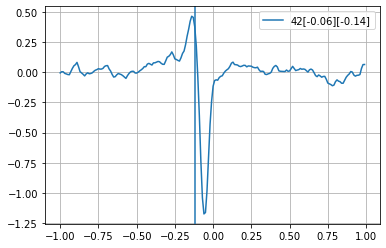

In [56]:
pcells = [20,33,40,42,53]
pcells = [42]
fig, ax = plt.subplots()
for channelnumber in pcells:
    rstate, _ = np.histogram(annots['Spikes'][0][channelnumber-1]-TimeStamps[0], np.append(0,T))
    time,cSTA, _= STA(rstate, x, x, dt, [-1,1])
    ax.plot(time,cSTA, label=str(channelnumber)+str(time[cSTA == min(cSTA)])+str(time[cSTA == max(cSTA)]))
ax.axvline(-0.12)
ax.legend()
ax.grid()
# fig = plt.gcf()
# ax = plt.gca()

(array([10], dtype=int64),)

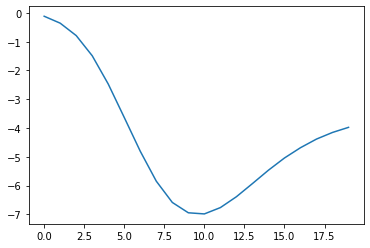

In [57]:
cstasum = []
for i in range(20):
    cstasum.append( sum(cSTA[100-i:100+1]))
plt.plot(cstasum)
np.where(np.array(cstasum)==min(cstasum))

-0.11999999999999922

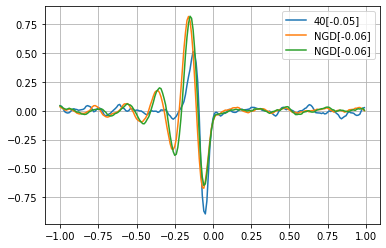

In [30]:
Lambda =  0.45
beta = (1-Lambda)/Lambda
alpha = 20. #1/sec
K = 23.
g = 40.
phi = 1.

y=np.zeros(len(T))
z=np.zeros(len(T))
s = TLfilter(x, 0.02, dt)
for k in range(len(T)-1):
    dy=dt*(-alpha*y[k]+K*(s[k]-phi*z[k]))
    dz=dt*(-beta*z[k]+g*y[k])
    y[k+1]=y[k]+dy
    z[k+1]=z[k]+dz
r = NL(np.mean(y)-y, 0)
ratio = sum(r)/T[-1]/12
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
rstate, _ = np.histogram(FakeSpike, np.append(0,T))
rstate = rstate.astype(int)

# x=np.random.randn(len(T))
time,cSTA, _= STA(rstate, x, x, dt, [-1,1])
ax.plot(time,cSTA,label = 'NGD'+str(time[cSTA == min(cSTA)]))
ax.legend()
fig

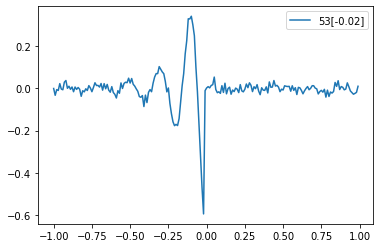

In [22]:
x=np.random.randn(len(T))
for k in range(len(T)-1):
    dy=dt*(-alpha*y[k]+K*(x[k]-phi*z[k]))
    dz=dt*(-beta*z[k]+g*y[k])
    y[k+1]=y[k]+dy
    z[k+1]=z[k]+dz
r = NL(np.mean(y)-y, 0)
ratio = sum(r)/T[-1]/12
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
rstate, _ = np.histogram(FakeSpike, np.append(0,T))
rstate = rstate.astype(int)
time,cSTA, _= STA(rstate, x, x, dt, [-1,1])
plt.plot(time,cSTA, label=str(channelnumber)+str(time[cSTA == min(cSTA)]))
plt.legend()

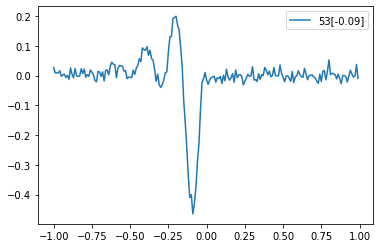

In [27]:
s = TLfilter(x, 0.12, dt)
for k in range(len(T)-1):
    dy=dt*(-alpha*y[k]+K*(s[k]-phi*z[k]))
    dz=dt*(-beta*z[k]+g*y[k])
    y[k+1]=y[k]+dy
    z[k+1]=z[k]+dz
r = NL(np.mean(y)-y, 0)
ratio = sum(r)/T[-1]/12
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
rstate, _ = np.histogram(FakeSpike, np.append(0,T))
rstate = rstate.astype(int)
time,cSTA, _= STA(rstate, x, x, dt, [-1,1])
plt.plot(time,cSTA, label=str(channelnumber)+str(time[cSTA == min(cSTA)]))
plt.legend()

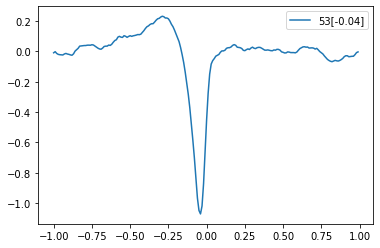

In [20]:
# x=np.random.randn(len(T))
s = TLfilter(x, 0.12, dt)
r1 = (1-Lambda)*s+Lambda*np.append(0,np.diff(s))/dt
r = NL(np.mean(r1)-r1, 0)
ratio = sum(r)/T[-1]/12
FakeSpike = Spike_Time_Generater(r/ratio, dt, 10)
rstate, _ = np.histogram(FakeSpike, np.append(0,T))
rstate = rstate.astype(int)
time,cSTA, _= STA(rstate, x, x, dt, [-1,1])
plt.plot(time,cSTA, label=str(channelnumber)+str(time[cSTA == min(cSTA)]))
plt.legend()